In [97]:
from simple_model.SimpleModel import cols, SimpleModel
import simple_model.GenerateSimpleModelData as gsm
import torch
import pyro.distributions as dist
import pandas as pd
import pyro
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def generate_policy_heatmap(filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    with torch.no_grad():
        df = pd.DataFrame()
        for i in range(50,90):
            for j in range(70,150):
                probs = [model.policy(torch.tensor([i, j]).float())[0].numpy().item(0), 
                        model.policy(torch.tensor([i, j]).float())[1].numpy().item(0)]
                prob_no_action = np.exp(probs[0])/(np.exp(probs[0]) + np.exp(probs[1]))
                df = df.append({'s_1': i, 's_2': j, 'prob-no-action': prob_no_action}, ignore_index=True)
        logit_probs = df.pivot("s_1", "s_2", "prob-no-action")
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
        sns.heatmap(logit_probs, vmax=0.50, ax=ax1)
        sns.heatmap(logit_probs, ax=ax2)
        plt.show()
    return df

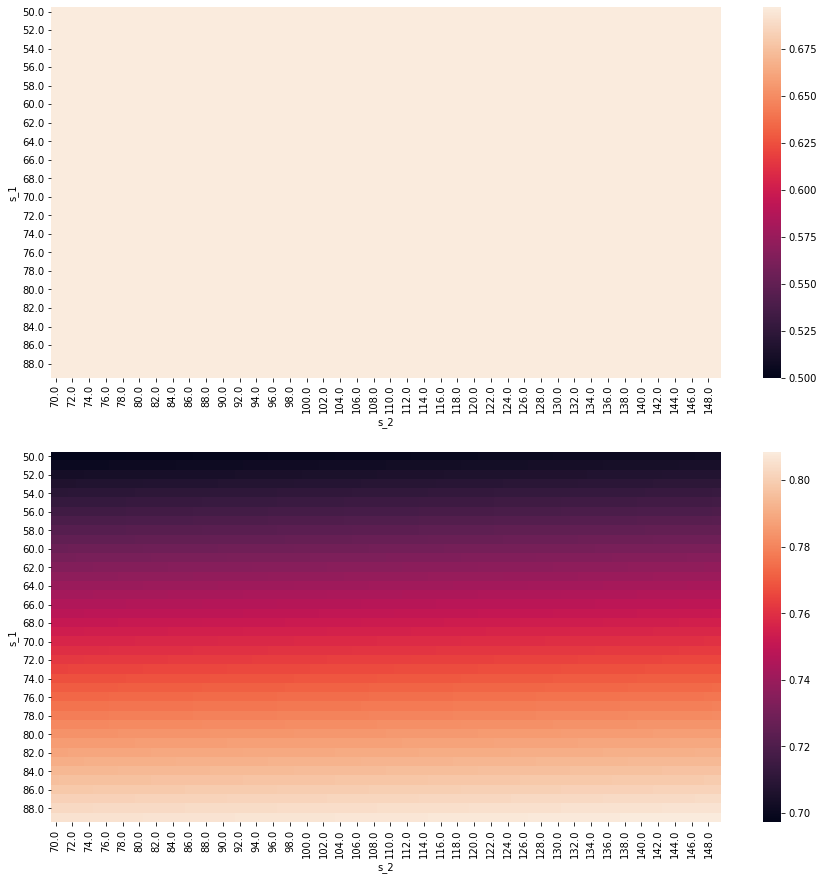

In [156]:
df = generate_policy_heatmap("/Users/faaiz/simple-model/model-state-(10, 10)")

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[-20, 20],[-20, 20]])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [152]:
df_guide = pd.DataFrame()
for i in range(10000):
    state = gsm.S_t()
    s0_1, s0_2 = state.s_t_1, state.s_t_2
    xt, ut = state.get_xt(), state.get_ut()
    action = gsm.physicians_policy(xt, ut)
    df_guide = df_guide.append({'s0_1': s0_1, 's0_2': s0_2, 'x0': xt, 'a0': action}, ignore_index=True)

In [232]:
def generate_simulator_heatmap(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    df = df[['s0_1', 's0_2', 'x0', 'a0']]
    df_0 = pd.DataFrame()
    df_1 = pd.DataFrame()
    with torch.no_grad():
        for index, row in df.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, xt = row['a0'], row['x0']
            s1_1 = dist.Normal(model.st_1_network(torch.tensor((s0_1, s0_2, action, xt)).float())[0].numpy().item(0),
                               torch.exp(model.st_1_network(torch.tensor((s0_1, s0_2, action, xt)).float())[1]).numpy().item(0)).sample()
            s1_2 = dist.Normal(model.st_2_network(torch.tensor((s0_1, s0_2, action, xt)).float())[0].numpy().item(0),
                               torch.exp(model.st_2_network(torch.tensor((s0_1, s0_2, action, xt)).float())[1]).numpy().item(0)).sample()
            if action == 0:
                df_0 = df_0.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1_1.numpy().item(0), 's1_2': s1_2.numpy().item(0)}, ignore_index=True)
            else:
                df_1 = df_1.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1_1.numpy().item(0), 's1_2': s1_2.numpy().item(0)}, ignore_index=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    img, extent = myplot(df_0['s1_1']-df_0['s0_1'], df_0['s1_2']-df_0['s0_2'], 16)
    ax1.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax1.set_title("$S_1$ for $A_0 = 0$")
    img, extent = myplot(df_1['s1_1']-df_1['s0_1'], df_1['s1_2']-df_1['s0_2'], 16)
    ax2.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax2.set_title("$S_1$ for $A_0 = 1$")
    plt.show()

In [233]:
def generate_simulator_heatmap_discarded(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    df = df.loc[:,['s0_1', 's0_2', 'x0', 'a0']]
    df_0 = df[df['a0']==0].copy()
    df_1 = df[df['a0']==1].copy()
    with torch.no_grad():
        t0, t1 = torch.tensor(df_0.values).float(), torch.tensor(df_1.values).float()
        mu1_0, sigma1_0 = model.st_1_network(t0)
        mu2_0, sigma2_0 = model.st_2_network(t0)
        mu1_1, sigma1_1 = model.st_1_network(t1)
        mu2_1, sigma2_1 = model.st_2_network(t1)
        s1_1_0 = dist.Normal(mu1_0.flatten(), torch.exp(sigma1_0.flatten())).sample()
        s2_1_0 = dist.Normal(mu2_0.flatten(), torch.exp(sigma2_0.flatten())).sample()
        s1_1_1 = dist.Normal(mu1_1.flatten(), torch.exp(sigma1_1.flatten())).sample()
        s2_1_1 = dist.Normal(mu2_1.flatten(), torch.exp(sigma2_1.flatten())).sample()
    df_0.loc[:, 's1_1'] = s1_1_0.numpy()
    df_0.loc[:, 's1_2'] = s2_1_0.numpy()
    df_1.loc[:, 's1_1'] = s1_1_1.numpy()
    df_1.loc[:, 's1_2'] = s2_1_1.numpy()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    img, extent = myplot(df_0['s1_1']-df_0['s0_1'], df_0['s1_2']-df_0['s0_2'], 16)
    ax1.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax1.set_title("$S_1$ for $A_0 = 0$")
    img, extent = myplot(df_1['s1_1']-df_1['s0_1'], df_1['s1_2']-df_1['s0_2'], 16)
    ax2.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax2.set_title("$S_1$ for $A_0 = 1$")
    plt.show()

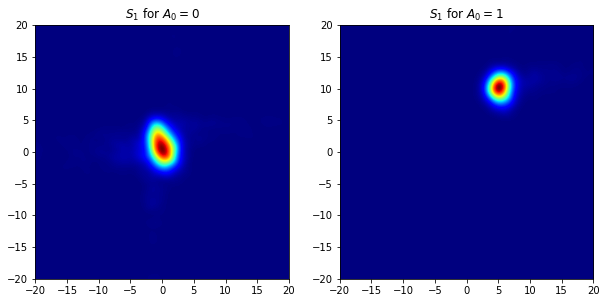

In [234]:
generate_simulator_heatmap(df_guide, "/Users/faaiz/simple-model/model-state-(10, 10)")